In [242]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from math import radians, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [237]:
cc_info = df = pd.read_csv(r"C:\Users\olive\OneDrive\Desktop\cc_info.csv")

In [196]:
transaction = df = pd.read_csv(r"C:\Users\olive\OneDrive\Desktop\transactions.csv")

In [197]:
cc_info.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [198]:
cc_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   credit_card        984 non-null    int64 
 1   city               984 non-null    object
 2   state              984 non-null    object
 3   zipcode            984 non-null    int64 
 4   credit_card_limit  984 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 38.6+ KB


In [199]:
cc_info.shape

(984, 5)

In [200]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   credit_card                294588 non-null  int64  
 1   date                       294588 non-null  object 
 2   transaction_dollar_amount  294588 non-null  float64
 3   Long                       294588 non-null  float64
 4   Lat                        294588 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 11.2+ MB


In [201]:
transaction.shape

(294588, 5)

In [202]:
data = transaction.merge(
    cc_info,
    on="credit_card",
    how="left"
)

In [203]:
data.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000


In [204]:
data.shape

(294588, 9)

In [205]:
data.isnull().sum()

credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
city                         0
state                        0
zipcode                      0
credit_card_limit            0
dtype: int64

In [206]:
### converting date to datetime 
### We can’t extract time-based fraud patterns unless Python understands this as time.
data["date"] = pd.to_datetime(data["date"])

In [207]:
#### creating time based fruad singnals 
data["hour"] = data["date"].dt.hour

In [208]:
data["is_weekend"] = (data["date"].dt.weekday >= 5).astype(int)
### 1 → Saturday or Sunday
### 0 → Monday–Friday

In [209]:
data["log_amount"] = np.log1p(data["transaction_dollar_amount"])

In [210]:
### Selecting features for fraud detection
features = [
    "log_amount",
    "Lat",
    "Long",
    "hour",
    "is_weekend",
    "credit_card_limit"
]

X = data[features]

In [211]:
###Scaling the features### 
### scaling is non-negotiable because amounts dominate latitude otherwise isolation Forest behaves much better on scaled data##
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [212]:
###training the isolation forest model###
iso = IsolationForest(n_estimators=300, contamination=0.02, random_state=42)

iso.fit(X_scaled)

IsolationForest(contamination=0.02, n_estimators=300, random_state=42)

In [213]:
data["anomaly"] = iso.predict(X_scaled)

### normal transaction
### anomalous (suspicious)

In [214]:
data["is_suspicious"] = (data["anomaly"] == -1).astype(int)
### 1 = suspicious
## 0 = normal

In [215]:
 data["is_suspicious"].value_counts(normalize=True)

is_suspicious
0    0.979999
1    0.020001
Name: proportion, dtype: float64

In [216]:
####sorting  out tranaction correctly###
###Velocity fraud only makes sense within the same card’s timeline###


data = data.sort_values(by=["credit_card", "date"])

In [217]:
###Creating previous transaction features####
### formmer transaction time ###
data["prev_time"] = data.groupby("credit_card")["date"].shift(1)


#### formmer lat and long###
data["prev_lat"] = data.groupby("credit_card")["Lat"].shift(1)
data["prev_long"] = data.groupby("credit_card")["Long"].shift(1)###(velocity fraud = current transaction vs formmer one)

In [218]:
data["time_diff_hours"] = ((data["date"] - data["prev_time"]).dt.total_seconds() / 3600)

In [219]:
###distance betwwen tranasction###
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)*2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)*2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

In [220]:
data["distance_km"] = haversine_vectorized(
    data["Lat"],
    data["Long"],
    data["prev_lat"],
    data["prev_long"]
)

C:\Users\olive\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [221]:
data["speed_kmh"] = data["distance_km"] / data["time_diff_hours"]
data["velocity_fraud"] = (data["speed_kmh"] > 900).astype(int)

In [222]:
data[["distance_km", "time_diff_hours", "speed_kmh"]].describe()

,distance_km,time_diff_hours,speed_kmh
count,145638.000000,293604.000000,1.456380e+05
mean,625.784238,7.131725,inf
std,1781.409262,15.123818,NaN
min,0.920231,0.000000,1.182504e-01
25%,266.296503,0.622778,3.850636e+01
50%,389.429205,1.760000,2.021971e+02
75%,508.386541,8.320139,6.337412e+02
max,19897.434609,1002.197500,inf


In [223]:
data["velocity_fraud"].value_counts()

velocity_fraud
0    266487
1     28101
Name: count, dtype: int64

In [224]:
### creating one final fraud flag###

data["final_fraud_flag"] = ((data["is_suspicious"] == 1) |(data["velocity_fraud"] == 1)).astype(int)

In [225]:
### checling how many transactions are flagged###
data["final_fraud_flag"].value_counts()

final_fraud_flag
0    261138
1     33450
Name: count, dtype: int64

In [226]:
data["final_fraud_flag"].value_counts(normalize=True)

final_fraud_flag
0    0.886452
1    0.113548
Name: proportion, dtype: float64

In [227]:
###inspecting the most extreme fraud cases###
data[data["final_fraud_flag"] == 1].sort_values(["speed_kmh", "transaction_dollar_amount"],ascending=False).head(10)

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,hour,...,anomaly,is_suspicious,prev_time,prev_lat,prev_long,time_diff_hours,distance_km,speed_kmh,velocity_fraud,final_fraud_flag
224109,7728317158402059,2015-09-17 19:43:01,104.20,-122.764997,37.728686,San Francisco,CA,94101,28000,19,...,1,0,2015-09-17 19:43:01,37.767386,-122.808062,0.000000,182.668862,inf,1,1
201405,7053196367895112,2015-10-28 21:34:58,101.92,-73.924052,40.722311,New York,NY,10001,18000,21,...,1,0,2015-10-28 21:34:58,40.796738,-73.947176,0.000000,416.377175,inf,1,1
236909,8028935620354401,2015-09-10 22:31:19,101.09,-76.361193,43.195988,Phoenix,NY,13135,12000,22,...,1,0,2015-09-10 22:31:19,43.192893,-76.341688,0.000000,143.550591,inf,1,1
269077,9246395935309352,2015-08-22 21:08:34,99.12,-74.717770,40.207895,Trenton,NJ,8601,30000,21,...,1,0,2015-08-22 21:08:34,40.289514,-74.687392,0.000000,530.651929,inf,1,1
143933,5275410446848007,2015-08-13 19:52:24,83.20,-80.210411,40.279128,Houston,PA,15342,18000,19,...,1,0,2015-08-13 19:52:24,40.252610,-80.141105,0.000000,198.005346,inf,1,1
246895,8325153881531522,2015-08-22 22:07:54,64.76,-111.962366,40.691462,Salt Lake City,UT,84101,20000,22,...,1,0,2015-08-22 22:07:54,40.770776,-111.951350,0.000000,492.747588,inf,1,1
43407,2246920751887814,2015-10-21 18:15:59,59.42,-81.514148,38.212790,Miami,WV,25134,9000,18,...,1,0,2015-10-21 18:15:59,38.148168,-81.373006,0.000000,253.028757,inf,1,1
281672,9594995194184360,2015-09-10 20:51:36,55.28,-72.085009,43.151237,Washington,NH,3280,20000,20,...,1,0,2015-09-10 20:51:36,43.257229,-72.073735,0.000000,563.496778,inf,1,1
33886,2018846126249619,2015-10-02 22:23:51,48.51,-76.008473,41.265261,Dallas,PA,18612,10000,22,...,1,0,2015-10-02 22:23:51,41.361173,-76.036969,0.000000,475.746692,inf,1,1
10240,1261411767321605,2015-10-28 22:59:52,156.18,-77.488439,42.473272,Atlanta,NY,14808,30000,22,...,1,0,2015-10-28 22:59:51,19.696954,103.656954,0.000278,19018.122270,6.846524e+07,1,1


In [228]:
#### understanding why each transaction was flagged###
def fraud_reason(row):
    if row["is_suspicious"] == 1 and row["velocity_fraud"] == 1:
        return "ML anomaly + impossible travel"
    elif row["is_suspicious"] == 1:
        return "ML anomaly"
    elif row["velocity_fraud"] == 1:
        return "Impossible travel"
    else:
        return "Normal"

data["fraud_reason"] = data.apply(fraud_reason, axis=1)

data[data["final_fraud_flag"] == 1]["fraud_reason"].value_counts()

fraud_reason
Impossible travel                 27558
ML anomaly                         5349
ML anomaly + impossible travel      543
Name: count, dtype: int64

In [229]:
### final check###
data[[
    "is_suspicious",
    "velocity_fraud",
    "final_fraud_flag",
    "fraud_reason"
]].head(15)

,is_suspicious,velocity_fraud,final_fraud_flag,fraud_reason
38,0,0,0,Normal
194,0,0,0,Normal
107,0,0,0,Normal
124,0,0,0,Normal
137,0,0,0,Normal
80,0,0,0,Normal
103,0,0,0,Normal
81,0,0,0,Normal
34,0,0,0,Normal
202,0,0,0,Normal


In [230]:
### threshold tunning (business perspective)###
data["velocity_fraud"] = (data["speed_kmh"] > 900).astype(int)

#### tried for multiple and i checked impact

for t in [500, 700, 900, 1200]:
    data[f"velocity_{t}"] = (data["speed_kmh"] > t).astype(int)



for t in [500, 700, 900, 1200]:
    print(t, data[f"velocity_{t}"].mean())

500 0.1458817059758035
700 0.1150861542221679
900 0.0953908509511589
1200 0.07695832824147623


In [231]:
data["fraud_label"] = data["final_fraud_flag"]

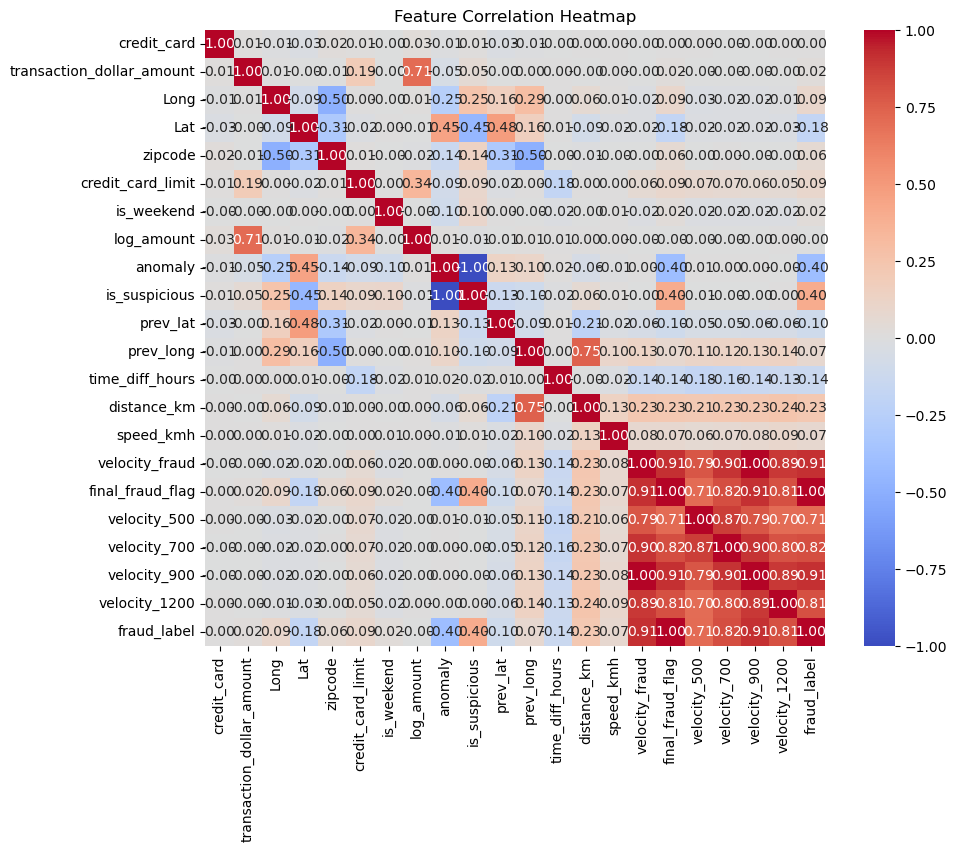

In [232]:
numeric_df = data.select_dtypes(include=['int64', 'float64'])

###  correlation matrix ###
corr = numeric_df.corr()

# ##plot heatmap ###
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [233]:
model_features = [
    "log_amount",
    "hour",
    "is_weekend",
    "time_diff_hours",
    "credit_card_limit"
]

# 2. Drop rows with structural NaNs
data_model = data.dropna(subset=model_features)

X = data_model[model_features]
y = data_model["fraud_label"]

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

lr = LogisticRegression(class_weight="balanced", max_iter=1000)
lr.fit(X_train_s, y_train)
y_prob = lr.predict_proba(X_test_s)[:, 1]


thresholds = np.arange(0.1, 0.9, 0.1)

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    p = precision_score(y_test, y_pred_t)
    r = recall_score(y_test, y_pred_t)
    print(f"Threshold {t:.1f} → Precision: {p:.2f}, Recall: {r:.2f}")

Threshold 0.1 → Precision: 0.14, Recall: 0.98
Threshold 0.2 → Precision: 0.15, Recall: 0.97
Threshold 0.3 → Precision: 0.15, Recall: 0.97
Threshold 0.4 → Precision: 0.15, Recall: 0.96
Threshold 0.5 → Precision: 0.18, Recall: 0.93
Threshold 0.6 → Precision: 0.27, Recall: 0.50
Threshold 0.7 → Precision: 0.47, Recall: 0.05
Threshold 0.8 → Precision: 1.00, Recall: 0.00


### Training a random foresst basline ###

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [240]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=50,
    min_samples_leaf=25,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=25,
                       min_samples_split=50, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [244]:
### making predictions ###
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]




### evaluating the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

[[43451  8595]
 [ 1212  5463]]
              precision    recall  f1-score   support

           0       0.97      0.83      0.90     52046
           1       0.39      0.82      0.53      6675

    accuracy                           0.83     58721
   macro avg       0.68      0.83      0.71     58721
weighted avg       0.91      0.83      0.86     58721

ROC AUC: 0.877234310587537
